# **Load Packages**

In [ ]:
# Install tensorflow-addons for Adamw optimizer
! pip install -U tensorflow-addons

In [ ]:
import tensorflow as tf
import keras
from keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import cifar100, cifar10
import tensorflow_datasets as tfds
from IPython.display import clear_output
from tensorflow.keras.utils import to_categorical
from scipy.stats import norm
import random
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from pylab import figure
import tensorflow_hub as hub
from sklearn.utils import shuffle
import cv2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import pickle
from sklearn.decomposition import PCA
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy, Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_recall_fscore_support
from keras.models import load_model
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import precision_recall_fscore_support
# Import the adaptative context normalization layer
package_dir = os.path.dirname(os.path.abspath(__file__))
root_dir = os.path.dirname(package_dir)
sys.path.append(root_dir)
from normalization.layers import AdaptativeContextNormalization

# **Define some functions**

In [ ]:
# Estimate the mean and variance in a given image dataset along channels axis
def compute_mean_std(dataset):
    data_r = np.dstack([dataset[i][:, :, 0] for i in range(len(dataset))])
    data_g = np.dstack([dataset[i][:, :, 1] for i in range(len(dataset))])
    data_b = np.dstack([dataset[i][:, :, 2] for i in range(len(dataset))])
    mean = np.mean(data_r), np.mean(data_g), np.mean(data_b)
    std = np.std(data_r), np.std(data_g), np.std(data_b)
    return mean, std

In [ ]:
# Define a Data Augmentation Layer
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(72, 72),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
  )

In [1]:
# Define functions to save lists and load files
def write_list(a_list, file_name):
    with open(file_name, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')

def read_list(file_name):
    with open(file_name, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

# **Configuration**

In [ ]:
class CFG:
    learning_rate = 0.001
    weight_decay = 0.0001
    batch_size = 216
    num_epochs = 500
    image_size = 72
    patch_size = 6
    num_patches = (image_size // patch_size) ** 2
    projection_dim = 64
    num_heads = 4
    epsilon = 0.01
    transformer_units = [
        projection_dim * 2,
        projection_dim,
    ]
    transformer_layers = 8
    mlp_head_units = [2048, 1024]
    input_shape = (32,32,3)
    num_classes = 100
    num_contexts = 20
    num_channels = 3

# **Load the CIFAR-100 dataset and create context**

In [ ]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Encode les labels au format one-hot sparse
y_train_sparse = to_categorical(y_train, num_classes=CFG.num_classes)
y_test_sparse = to_categorical(y_test, num_classes=CFG.num_classes)

# Preprocess CIFAR-100 dataset
mean, std = compute_mean_std(x_train)
x_train = x_train.astype('float32')
x_train = (x_train - mean) / std
x_test = x_test.astype('float32')
x_test = (x_test - mean) / std

# Use superclass IDs from CIFAR-100 as context
(train, y_train_context), (test, y_test_context) = cifar100.load_data(label_mode='coarse')
y_train_context = y_train_context.flatten()
y_test_context = y_test_context.flatten()

# **Define some layers for the Vision Transformer architecture**

In [ ]:
# Feed Forward Network
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Embedding layer
class EmbeddingLayer(tf.keras.layers.Layer):
  def __init__(self, vocab_size, emb_dim, **kwargs):
    super(**kwargs).__init__()
    self.vocab_size = vocab_size
    self.emb_dim = emb_dim

  def build(self, input_shape):
    super().build(input_shape)
    self.emb = tf.keras.layers.Embedding(self.vocab_size+1, self.emb_dim)

  def call(self, x):
    emb = self.emb(x)
    return emb

In [ ]:
# Create patch and vectors
class Patches(tf.keras.layers.Layer):
    def __init__(self, patch_size, **argws):
        super(**argws).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Patches encoder
class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim, **argws):
        super(**argws).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim

    def build(self, input_shape):
      super().build(input_shape)
      self.projection = tf.keras.layers.Dense(units=self.projection_dim)
      self.position_embedding = EmbeddingLayer(self.num_patches, self.projection_dim) # or use positional encoding

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# **Create the Vision Transformer model**

In [ ]:
def build_model(input_shape=CFG.input_shape, num_contexts=CFG.num_contexts, num_channels=CFG.num_channels,
                projection_dim=CFG.projection_dim, patch_size=CFG.patch_size, transformer_units=CFG.transformer_units,
                num_patches=CFG.num_patches, learning_rate=CFG.learning_rate, weight_decay=CFG.weight_decay, num_classes=CFG.num_classes,
                num_heads=CFG.num_heads, transformer_layers=CFG.transformer_layers, mlp_head_units=CFG.mlp_head_units):

    input_image = layers.Input(shape=input_shape)
    context_id = layers.Input(shape=(1,), dtype='int32')

    # Normalize inputs with context normalization
    normalized_inputs = AdaptativeContextNormalization(num_contexts, name="acn")([input_image, context_id])
    # Augment data.
    augmented = data_augmentation(normalized_inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6, name="vis")(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=[input_image, context_id], outputs=logits)
    #baseline_model.summary()
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        Precision(name="precision"),
        Recall(name="recall"),
        tfa.metrics.F1Score(num_classes=num_classes, name="f1-score")

    ],
    )
    return model

# **Train the model**

In [ ]:
def run_model(model, filepath, batch_size=CFG.batch_size, num_epochs=CFG.num_epochs):

    checkpoint_filepath = filepath
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=[x_train, y_train_context],
        y=y_train_sparse,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy, precision, recall, f1 = model.evaluate([x_test, y_test_context], y_test_sparse)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    print(f"precision: {round(precision * 100, 2)}%")
    print(f"recall: {round(recall * 100, 2)}%")
    print(f"f1: {f1}")

    return history

with tf.device('/device:GPU:0'):
  model = build_model()
  history = run_model(model, "model.ckpt")

In [1]:
# Model performance after convergence in test dataset
model.load_weights("model.ckpt")
loss, accuracy, top_5_accuracy, precision, recall, f1 = model.evaluate([x_test, y_test_context], y_test_sparse)
print(f"loss: {loss}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
print(f"precision: {round(precision * 100, 2)}%")
print(f"recall: {round(recall * 100, 2)}%")
print(f"f1: {np.array(f1).mean(axis=-1)}")

loss: 0.92
Test accuracy: 67.38%
Test top 5 accuracy: 99.60%
precision: 22.93%
recall: 99.00%
f1: 67.13%


In [ ]:
# See model generalization (loss and validation loss)
loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.figure(figsize=(10, 6))
plt.plot(loss, 'bo', label='Training Loss', linewidth=4)
plt.plot(validation_loss, 'r', label='Validation Loss', linewidth=4)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

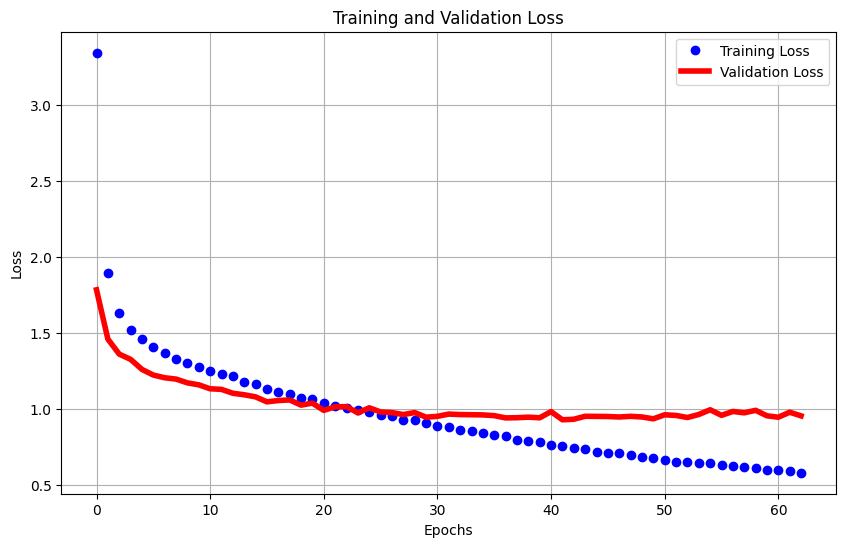

In [15]:
# See model generalization (loss and validation loss)
loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.figure(figsize=(10, 6))
plt.plot(loss, 'bo', label='Training Loss', linewidth=4)
plt.plot(validation_loss, 'r', label='Validation Loss', linewidth=4)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

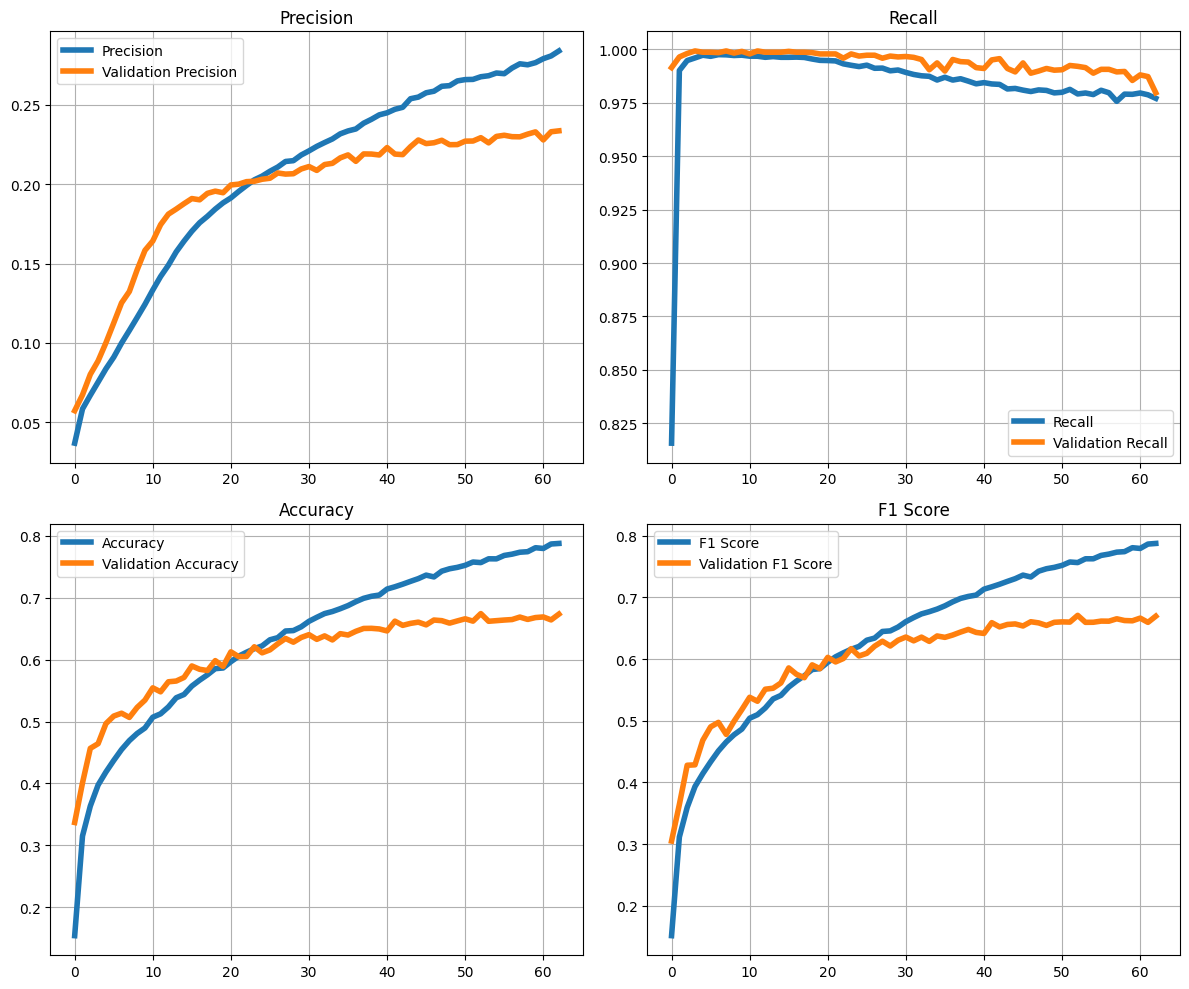

In [14]:
# Plot metrics evolution
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes[0, 0].plot(history.history['precision'], linewidth=4, label='Precision')
axes[0, 0].plot(history.history['val_precision'], linewidth=4, label='Validation Precision')
axes[0, 0].set_title('Precision')
axes[0, 0].grid(True)
axes[0, 0].legend()

axes[0, 1].plot(history.history['recall'], linewidth=4, label='Recall')
axes[0, 1].plot(history.history['val_recall'], linewidth=4, label='Validation Recall')
axes[0, 1].set_title('Recall')
axes[0, 1].grid(True)
axes[0, 1].legend()

axes[1, 0].plot(history.history['accuracy'], linewidth=4, label='Accuracy')
axes[1, 0].plot(history.history['val_accuracy'], linewidth=4, label='Validation Accuracy')
axes[1, 0].set_title('Accuracy')
axes[1, 0].grid(True)
axes[1, 0].legend()

axes[1, 1].plot(np.array(history.history['f1']).mean(axis=-1), linewidth=4, label='F1 Score')
axes[1, 1].plot(np.array(history.history['val_f1']).mean(axis=-1), linewidth=4, label='Validation F1 Score')
axes[1, 1].set_title('F1 Score')
axes[1, 1].grid(True)
axes[1, 1].legend()

plt.tight_layout()

plt.show()


In [ ]:
# Save metrics
write_list(history.history['accuracy'], 'accuracy')
write_list(history.history['val_accuracy'], 'val_accuracy')
write_list(history.history['loss'], 'loss')
write_list(history.history['val_loss'], 'val_loss')
write_list(history.history['precision'], 'precision')
write_list(history.history['val_precision'], 'val_precision')
write_list(history.history['recall'], 'recall')
write_list(history.history['val_recall'], 'val_recall')
write_list(history.history['val_f1-score'], 'val_f1')
write_list(history.history['f1-score'], 'f1')

# **Visualization**

In [ ]:
# Load model
model = build_model()
model.load_weights("model.ckpt")

## **Gradient**

**Interpreting Gradient Statistics for Model Stability**

In our investigation, we conducted an in-depth analysis of gradient statistics to evaluate the training stability of our model. The calculated mean gradients, falling within the range of -0.01 to 0.04, indicate a modest bias towards weight updates during training. This suggests that, on average, gradients exhibit a slight tendency to either increase or decrease model parameters but remain relatively close to zero. Moreover, the standard deviations of gradients, which span from 0.4 to 0.7, indicate a moderate level of variability in gradient magnitudes across training batches. This moderate variability, combined with the near-zero mean, suggests a balanced training process where weight updates are not excessively influenced in any single direction, contributing to the model's stability. These gradient statistics offer valuable insights into the training dynamics, indicating a favorable compromise between rapid convergence and resistance to noise in the training data.

In [ ]:
stability_threshold = 1
stable_layers = [i for i, std in enumerate(std_gradients) if std < stability_threshold]
selected_mean_gradients = [mean_gradients[i] for i in stable_layers]
selected_std_gradients = [std_gradients[i] for i in stable_layers]
[layer_indices[i] for i in stable_layers]

In [ ]:
# Define a function to calculate gradients for specific layers
def get_gradients(model, layer_indices, input_data):
    gradients_list = []
    x_input = tf.convert_to_tensor(input_data[0], dtype=tf.float32)
    context_input = tf.convert_to_tensor(input_data[1], dtype=tf.int32)
    separate_models = [tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_index).output) for layer_index in layer_indices]

    for separate_model in separate_models:
        with tf.GradientTape() as tape:
            tape.watch(x_input)
            layer_output = separate_model([x_input, context_input])

        gradients = tape.gradient(layer_output, x_input)
        gradients_list.append(gradients)

    return gradients_list

# Specify the layer names or indices for which you want to calculate gradients
layer_indices = [f"dense_{i}" for i in range(1, 19)]  # For example, layers "dense_1" and "dense_2"

# Initialize lists to store gradient statistics
mean_gradients = []
std_gradients = []

# Prepare input data (replace with your actual data)
input_data = [x_train[:100], y_train_context[:100]]
excluded_layer_types = ['Dropout', 'InputLayer', 'LayerNormalization', 'DataAugmentation', 'Patches', 'PatchEncoder', 'Add', 'Flatten']
layer_indices = [layer.name for layer in model.layers if layer.__class__.__name__ not in excluded_layer_types][2:]


# Calculate gradients for specified layers
gradients_list = get_gradients(model, layer_indices, input_data)

# Calculate mean and standard deviation of gradients for each layer
for gradients in gradients_list:
    mean_gradient = tf.reduce_mean(gradients)
    std_gradient = tf.math.reduce_std(gradients)
    mean_gradients.append(mean_gradient.numpy())
    std_gradients.append(std_gradient.numpy())

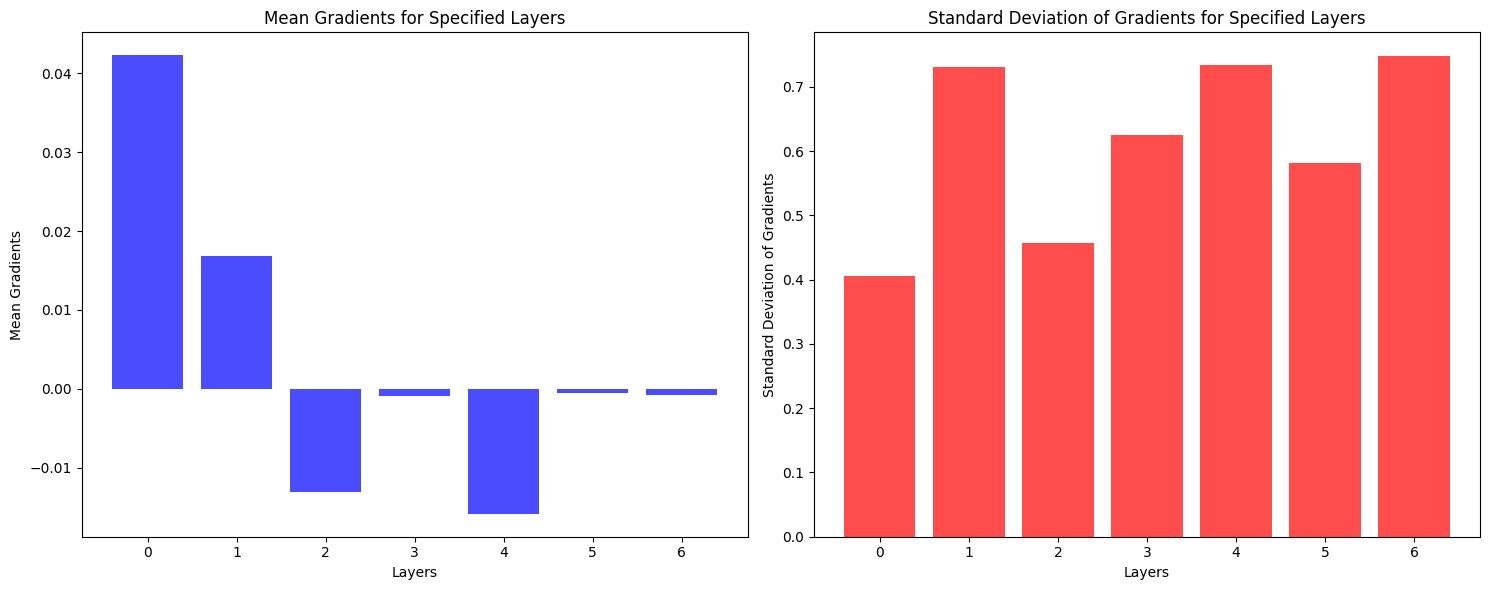

In [ ]:
# Layer names for plotting (replace with your actual layer names)
layer_names = [i for i in range(len(selected_mean_gradients))]

# Create subplots for vertical bar charts to visualize mean gradients
plt.figure(figsize=(15, 6))

# Subplot 1: Mean Gradients
plt.subplot(1, 2, 1)
plt.bar(layer_names, selected_mean_gradients, color='blue', alpha=0.7)
plt.ylabel('Mean Gradients')
plt.title('Mean Gradients for Specified Layers')
plt.xlabel("Layers")

# Subplot 2: Standard Deviation of Gradients
plt.subplot(1, 2, 2)
plt.bar(layer_names, selected_std_gradients, color='red', alpha=0.7)
plt.ylabel('Standard Deviation of Gradients')
plt.title('Standard Deviation of Gradients for Specified Layers')
plt.xlabel("Layers")

plt.tight_layout()
plt.show()


## **Scatter using outputs of the last layer of the model**

In [ ]:
# Computer embeddings in the second last layer
second_last_layer = model.layers[-2]
second_last_model = tf.keras.Model(inputs=model.input, outputs=second_last_layer.output)
predictions = second_last_model.predict([x_train[:10000], y_train_context[:10000]])

313/313 [==============================] - 210s 663ms/step


In [ ]:
# Reduce dimension with pca
num_components = 5
pca = PCA(n_components=num_components)
pca_results = pca.fit_transform(predictions)

<ipython-input-64-fb4f4432ef68>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', num_classes)


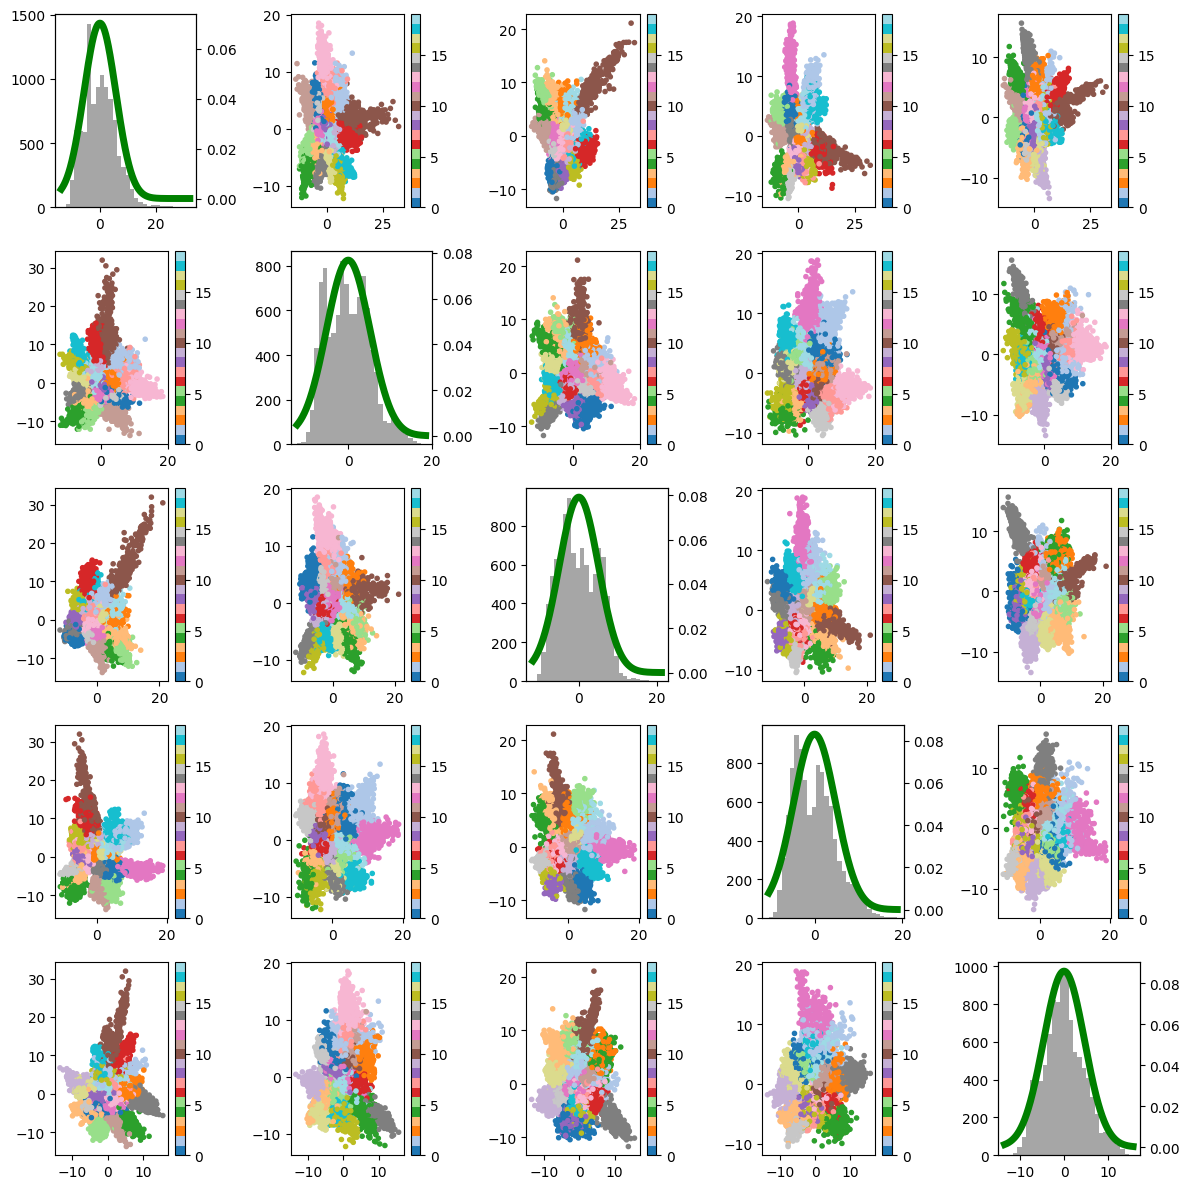

In [ ]:
num_classes = len(np.unique(y_train_context[:10000]))
cmap = plt.cm.get_cmap('tab20', num_classes)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_components, ncols=num_components, figsize=(12, 12))

# Loop to create cross-component visualizations
for i in range(num_components):
    for j in range(num_components):
        if i == j:
            axes[i, j].hist(pca_results[:, i], bins=30, color='gray', alpha=0.7)
            #axes[i, j].set_xlabel(f'Component {i+1}')
            #axes[i, j].set_ylabel(f'Frequency')
            # Compute PDF (Probability Density Function)
            mean = np.mean(pca_results[:, i])
            std_dev = np.std(pca_results[:, i])
            x = np.linspace(np.min(pca_results[:, i]), np.max(pca_results[:, i]), 1000)
            pdf = norm.pdf(x, mean, std_dev)

            # Plot PDF
            axes_pdf = axes[i, j].twinx()
            axes_pdf.plot(x, pdf, 'g', label='PDF', linewidth=5.0)
        else:
            scatter = axes[i, j].scatter(pca_results[:, i], pca_results[:, j], marker='.', c=y_train_context[:10000], cmap=cmap)
            #axes[i, j].set_xlabel(f'Component {i+1}')
            #axes[i, j].set_ylabel(f'Component {j+1}')
            fig.colorbar(scatter, ax=axes[i, j])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()